In [1]:
!pip install beautifulsoup4 chardet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, tree, linear_model, naive_bayes, metrics, svm

# Data

In [3]:
!wget -qO- https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2 | tar -xjf -
!wget -qO- https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2 | tar -xjf -

!cat spam/00001.7848dde101aa985090474a91ec93fcf0 | tail
!cat easy_ham/00001.7c53336b37003a9286aba55d2945844c | tail

REMOVE. If you 
      reside in any state which prohibits e-mail solicitations for insuran=
ce, 
      please disregard this 
      email.<BR></FONT><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR=
><BR><BR><BR></FONT></P></CENTER></CENTER></TR></TBODY></TABLE></CENTER></=
CENTER></CENTER></CENTER></CENTER></BODY></HTML>



ps: this is still using the version of the code form a day ago, I haven't
been able to reach the cvs repository today (local routing issue I think).



_______________________________________________
Exmh-workers mailing list
Exmh-workers@redhat.com
https://listman.redhat.com/mailman/listinfo/exmh-workers



In [4]:
from pathlib import Path
from chardet import detect

def file_bodies(file_path):
    result = []
    path_list = Path(file_path).glob('**/00*')
    for path in path_list:
        # path is object not string
        path_str = str(path)
        with open('spam/00001.7848dde101aa985090474a91ec93fcf0', 'rb') as enc_file:
            char_det = detect(enc_file.read())['encoding']
            enc_file.close()
            with open(path_str, 'r', encoding=char_det) as spam_file:
                file_body = None
                try:
                    file_body = spam_file.read()
                    result.append(file_body)
                except UnicodeDecodeError as err:
                    pass
                    # print(err)
                spam_file.close()
    return result

In [5]:
import re
from bs4 import BeautifulSoup

def file_bodies_cleaned(file_bodies: list):
    result = []
    for file_body in file_bodies:
        file_body_wo_header = re.sub(r'.*\:\s.*|From\s.*@', ' ', file_body)
        soup = BeautifulSoup(file_body_wo_header)
        result.append(soup.get_text())
    return result

# EDA

In [6]:
spam_file_bodies_cleaned = file_bodies_cleaned(file_bodies('./spam/'))
ham_file_bodies_cleaned = file_bodies_cleaned(file_bodies('./easy_ham/'))

In [7]:
rows = len(spam_file_bodies_cleaned) + len(ham_file_bodies_cleaned)
cols = 0

spam_email_df = pd.DataFrame()
spam_email_df['text'] = spam_file_bodies_cleaned
spam_email_df['label'] = 'spam'

ham_email_df = pd.DataFrame()
ham_email_df['text'] = ham_file_bodies_cleaned
ham_email_df['label'] = 'ham'

df = pd.DataFrame()
df = df.append(spam_email_df)
df = df.append(ham_email_df)

<ipython-input-7-e291f057f0e0>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(spam_email_df)
<ipython-input-7-e291f057f0e0>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(ham_email_df)


In [8]:
df.tail()


,text,label
923,xent.com Mon Aug 26 15:32:10 2002\n \n \n \n\...,ham
924,xent.com Fri Aug 23 11:09:07 2002\n \n \n \n\...,ham
925,xent.com Thu Sep 19 16:26:17 2002\n \n \n \n\...,ham
926,redhat.com Mon Sep 9 20:33:50 2002\n \n \n \...,ham
927,linux.ie Tue Oct 8 12:26:48 2002\n \n \n \n\...,ham


In [9]:
df.describe()

,text,label
count,1343,1343
unique,1343,2
top,datapart.no Wed Sep 25 10:29:33 2002\n \n \n ...,ham
freq,1,928


In [10]:
df['length'] = df['text'].apply(len)
df.head(5)

,text,label,length
0,datapart.no Wed Sep 25 10:29:33 2002\n \n \n ...,spam,2254
1,linux.ie Fri Sep 6 11:40:00 2002\n \n \n \n\...,spam,3532
2,aol.com Tue Oct 8 11:02:32 2002\n \n \n \n\t...,spam,1786
3,aol.com Mon Sep 9 19:31:37 2002\n \n \n \n\t...,spam,9570
4,by sonic.spamtraps.taint.org (Postfix) with SM...,spam,38082


<Axes: ylabel='Frequency'>

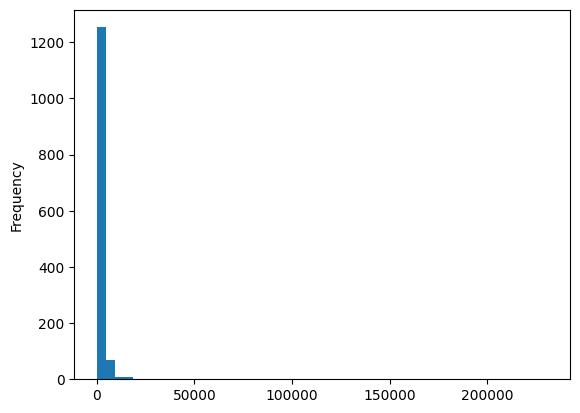

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
df['length'].plot(bins=50, kind='hist')

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

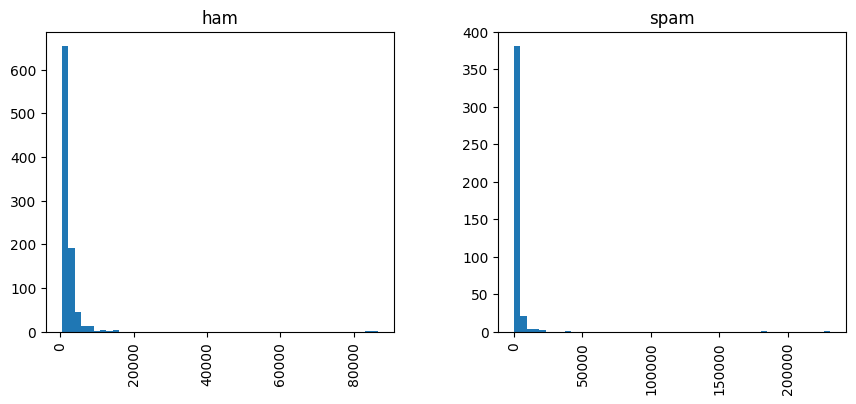

In [12]:
df.hist(column='length', by='label', bins=50,figsize=(10,4))

In [13]:
count1 = Counter(" ".join(df[df['label']=='ham']["text"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(df[df['label']=='spam']["text"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

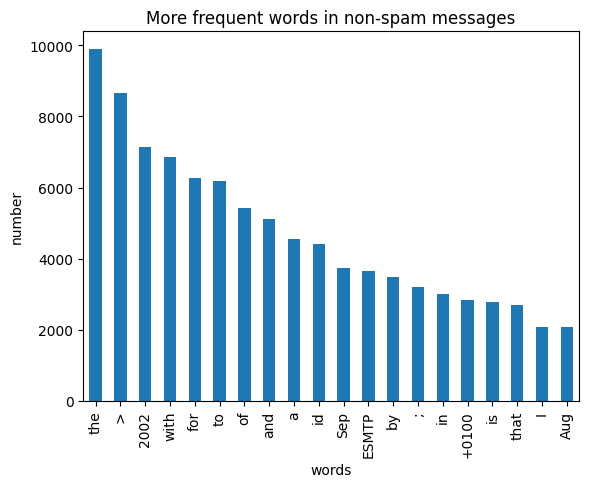

In [14]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

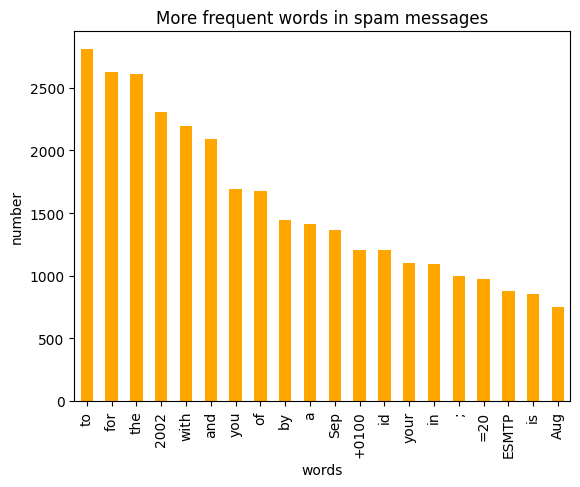

In [15]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [16]:
df

,text,label,length
0,datapart.no Wed Sep 25 10:29:33 2002\n \n \n ...,spam,2254
1,linux.ie Fri Sep 6 11:40:00 2002\n \n \n \n\...,spam,3532
2,aol.com Tue Oct 8 11:02:32 2002\n \n \n \n\t...,spam,1786
3,aol.com Mon Sep 9 19:31:37 2002\n \n \n \n\t...,spam,9570
4,by sonic.spamtraps.taint.org (Postfix) with SM...,spam,38082
...,...,...,...
923,xent.com Mon Aug 26 15:32:10 2002\n \n \n \n\...,ham,1766
924,xent.com Fri Aug 23 11:09:07 2002\n \n \n \n\...,ham,739
925,xent.com Thu Sep 19 16:26:17 2002\n \n \n \n\...,ham,2235
926,redhat.com Mon Sep 9 20:33:50 2002\n \n \n \...,ham,1609


In [17]:
df.loc[:,'label'] = df.label.map({'ham':0, 'spam':1})
print(df.shape)
df.head()

(1343, 3)


<ipython-input-17-4328a1da56a9>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'label'] = df.label.map({'ham':0, 'spam':1})


,text,label,length
0,datapart.no Wed Sep 25 10:29:33 2002\n \n \n ...,1,2254
1,linux.ie Fri Sep 6 11:40:00 2002\n \n \n \n\...,1,3532
2,aol.com Tue Oct 8 11:02:32 2002\n \n \n \n\t...,1,1786
3,aol.com Mon Sep 9 19:31:37 2002\n \n \n \n\t...,1,9570
4,by sonic.spamtraps.taint.org (Postfix) with SM...,1,38082
